## Урок 5. Домашнее задание

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report,\
                            precision_recall_curve, confusion_matrix

from catboost import CatBoostClassifier

%matplotlib inline

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

Скопируем предобработку и полезные функции, показанные на лекции.

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
df = pd.read_csv("lection5_materials/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))
    

feats = FeatureUnion(final_transformers)

Скопируем модель на базе случайного леса, представленную на лекции.

In [7]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


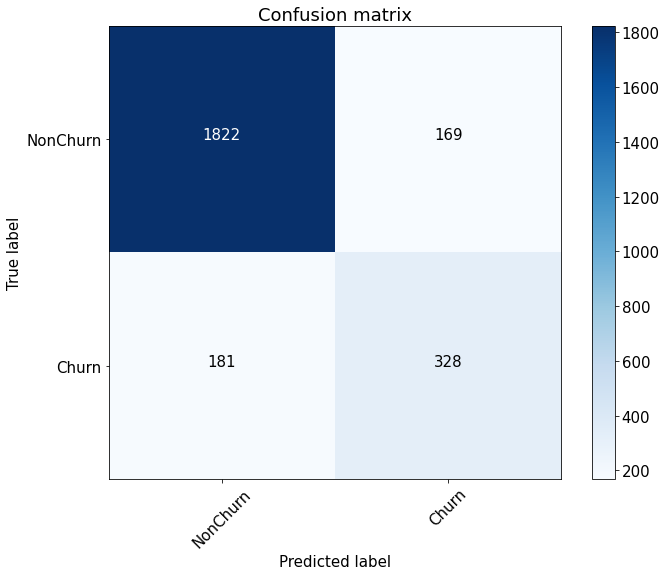

In [8]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Градиентный бустинг

Теперь реализуем пайплайн на основе бустинга.

In [9]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Подберем оптимальные параметры модели с помощью перебора параметров по сетке.

In [10]:
params_gb={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__n_estimators':[50, 100, 150, 200],
        'classifier__max_depth':[3, 5, 7],
        'classifier__learning_rate':[0.01, 0.05, 0.1, 0.2],
        }

In [11]:
grid_gb = GridSearchCV(pipeline_gb,
                    param_grid=params_gb,
                    cv=6,
                    refit=False)

search_gb = grid_gb.fit(X_train, y_train)
search_gb.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__max_features': 0.5,
 'classifier__n_estimators': 200}

Обучим модель с найденными параметрами, рассчитаем метрики и построим матрицу ошибок.

In [12]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.1, max_depth=3, max_features=0.5, 
                                              n_estimators=200, random_state=42)),
])

pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.351016, F-Score=0.648, Precision=0.645, Recall=0.650
Confusion matrix, without normalization
[[1809  182]
 [ 179  330]]


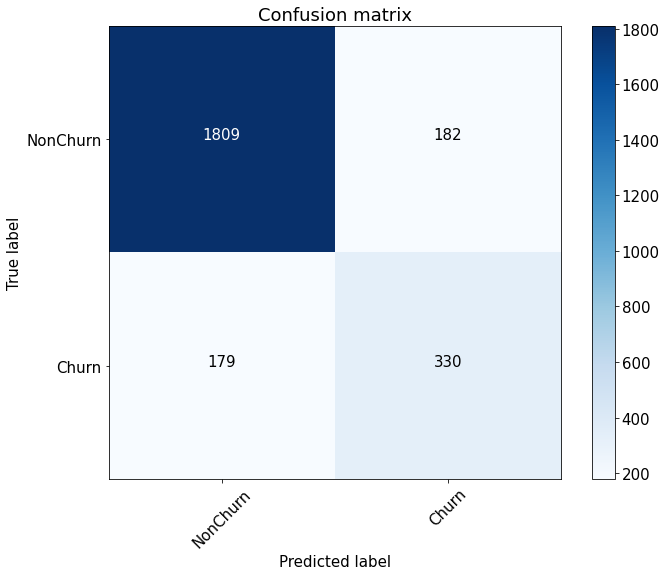

In [13]:
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)
fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_gb.png")
plt.show()

Как видим `F-score` получившейся модели градиентного бустинга несколько хуже, чем для построенного ранее случайного леса. Попробуем еще обучить Catboost. В данном случае можно не проводить энкодинг категориальных переменных.

### CatBoost

In [14]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.column]]


categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for col in categorical_columns+continuous_columns:
    transformer = Pipeline([
                ('selector', Selector(column=col)),
            ])
    final_transformers.append((col, transformer))
    

feats = FeatureUnion(final_transformers)

Подберем оптимальные параметры с помощью перебора по сетке.

In [15]:
pipeline_cb = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(cat_features=np.arange(len(categorical_columns)), 
                                      random_state=42, silent=True)),
])

pipeline_cb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='HasCrCard'))])),
                       

In [16]:
params_cb={'classifier__n_estimators':[50, 100, 150, 200],
        'classifier__max_depth':[3, 5, 7],
        'classifier__learning_rate':[0.01, 0.05, 0.1, 0.2],
        'classifier__subsample':[0.3, 0.5, 0.7, 0.9],
        }

In [17]:
grid_cb = GridSearchCV(pipeline_cb,
                    param_grid=params_cb,
                    cv=6,
                    refit=False)

search_cb = grid_cb.fit(X_train, y_train)
search_cb.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 200,
 'classifier__subsample': 0.3}

Теперь обучим модель и посчитаем метрики.

In [18]:
pipeline_cb = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(learning_rate=0.1, max_depth=5,
                                      n_estimators=200, subsample=0.3,
                                      cat_features=np.arange(len(categorical_columns)), 
                                      random_state=42, silent=True)),
])

pipeline_cb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  Selector(column='HasCrCard'))])),
                       

Best Threshold=0.374294, F-Score=0.659, Precision=0.667, Recall=0.650
Confusion matrix, without normalization
[[1826  165]
 [ 179  330]]


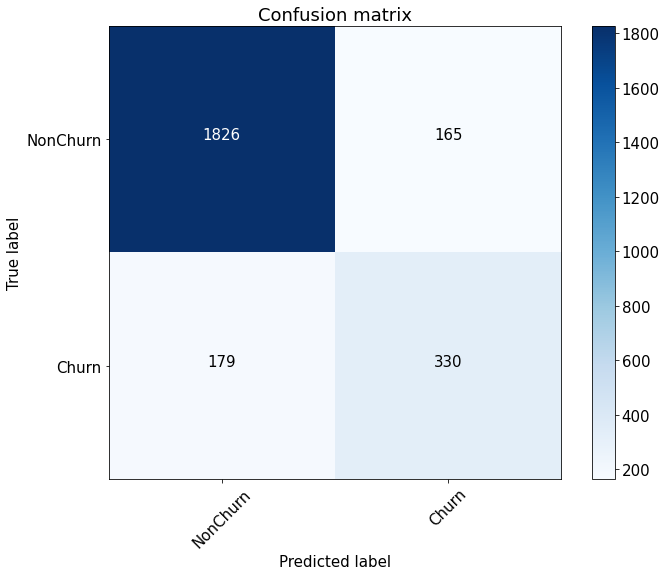

In [19]:
preds_cb = pipeline_cb.predict_proba(X_test)[:, 1]
precision_cb, recall_cb, thresholds_cb = precision_recall_curve(y_test, preds_cb)
fscore_cb = (2 * precision_cb * recall_cb) / (precision_cb + recall_cb)
# locate the index of the largest f score
ix_cb = np.argmax(fscore_cb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_cb[ix_cb], 
                                                                        fscore_cb[ix_cb],
                                                                        precision_cb[ix_cb],
                                                                        recall_cb[ix_cb]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_cb>thresholds_cb[ix_cb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_cb.png")
plt.show()

Как видим метрики данной модели лучше, чем для случайного леса, представленного на лекции.

### Логистическая регрессия

В данной модели нужно добавить стандартизацию вещественных признаков.

In [20]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    

feats = FeatureUnion(final_transformers)

In [21]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=42)),
])

pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Посчитаем метрики и построим матрицу ошибок.

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


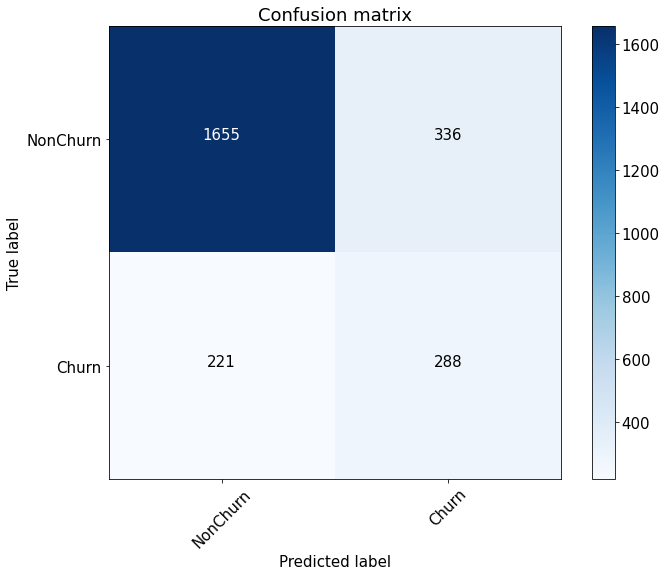

In [22]:
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)
fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix_lr], 
                                                                        fscore_lr[ix_lr],
                                                                        precision_lr[ix_lr],
                                                                        recall_lr[ix_lr]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_lr>thresholds_lr[ix_lr])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_lr.png")
plt.show()

Результаты получились хуже, чем для других моделей.

2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Выбор метрики в данном случае, на мой взгляд, зависит прежде всего от конкретной постановки задачи. 

Например, если мы хотим минимизировать количество уходящих от нас клиентов, то нужно сконцентрироваться на минимизации количества клиентов, для которых мы делаем некорректное предсказание, что они не уйдут. То есть мы как можно полнее хотим охватить класс уходящих клиентов, и поэтому должны в таком случае сконцентрироваться на показателе полноты - `Recall`.

Если же для каждого клиента, которого мы помечаем как уходящего, делается довольно дорогое (с точки зрения фирмы) предложение, то нужно не допустить большого количества случаев, когда было сделано предложение клиенту, который на самом деле не собирался уходить. То есть нужно мимнимизировать количество ошибок первого рода, а значит максимизировать показатель точности - `Precision`.

Если же оба этих момента одинаково важны, то оптимальным будет использование метрики `F1-score`.

Выведем сводную таблицу с результатами для разных моделей.

In [23]:
df = pd.DataFrame([['rf', precision[ix], recall[ix], fscore[ix], roc_auc_score(y_test, preds)], 
                   ['gb', precision_gb[ix_gb], recall_gb[ix_gb], fscore_gb[ix_gb], roc_auc_score(y_test, preds_gb)],
                   ['сb', precision_cb[ix_cb], recall_cb[ix_cb], fscore_cb[ix_cb], roc_auc_score(y_test, preds_cb)],
                   ['logreg', precision_lr[ix_lr], recall_lr[ix_lr], fscore_lr[ix_lr], roc_auc_score(y_test, preds_lr)]], 
                   columns=['method', 'precision', 'recall', 'fscore', 'roc_auc'])
df

,method,precision,recall,fscore,roc_auc
0,rf,0.660643,0.646365,0.653426,0.869511
1,gb,0.645224,0.650295,0.647750,0.872163
2,сb,0.667339,0.650295,0.658706,0.877975
3,logreg,0.462400,0.567780,0.509700,0.772077


Максимальное значение `Recall` дают бустинги, но у CatBoost выше метрика точности, поэтому, на мой взгляд, лучшей моделью в данном случае является __CatBoost__.

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

Выведем еще раз матрицу ошибок для модели CatBoost.

Confusion matrix, without normalization
[[1826  165]
 [ 179  330]]


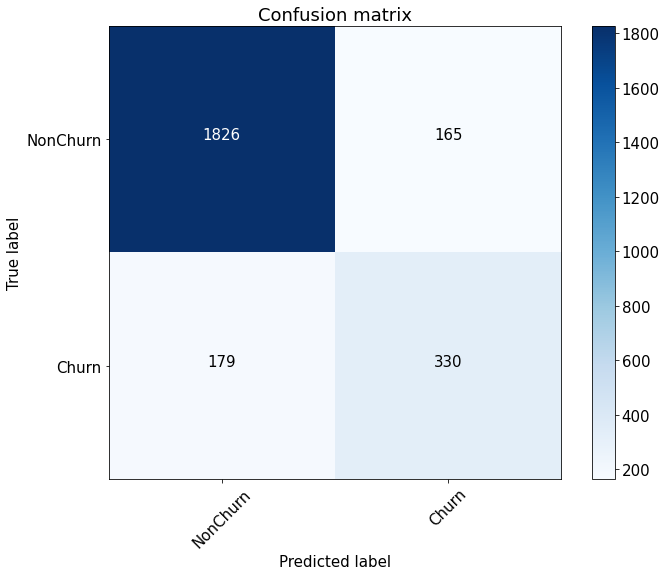

In [24]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_cb>thresholds_cb[ix_cb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

Для данной модели получается, что мы потратим на удержание клиентов 330 + 165 = _495 долларов_, а заработаем 330 * 2 = _660 долларов_. Таким образом прибыль от проведенной кампании составит __165 долларов__. Для сравнения прибыль для модели на основе случайного леса, представленной в лекции, при тех же вводных составит 328 * 2 - 328 - 169 = 159 долларов. Для логистической регрессии такая акция окажется экономически неэффективной и приведет к убытку в размере 288 * 2 - 288 - 336  = 48 долларов. Для градиентного бустинга прибыль составит 330 * 2 - 330 - 182 = 148 долларов.

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

Гиперпараметры для моделей были подобраны с помощью перебора по сетке при изначальном построении.